## Analyzing 2015-19 ACS Data 

This notebook contains the code used to wrangle, join, and analyze the following datasets:

+ American Community Survey (ACS) 5-year estimates (2015-2019)
    + [Aggregate](https://api.census.gov/data/2019/acs/acs5/variables.html)
    + [Profile](https://api.census.gov/data/2019/acs/acs5/profile/variables.html)

+ Chicago Community Area Census Tract Crosswalk
    + [Chicago Community Areas](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)
    + [Chicago Census Tracts](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik)
+ [Chicago COVID-19 Community Vulnerability Index (CCVI)](https://data.cityofchicago.org/Health-Human-Services/Chicago-COVID-19-Community-Vulnerability-Index-CCV/xhc6-88s9)
+ [Hardship Index](https://data.cityofchicago.org/Health-Human-Services/hardship-index/792q-4jtu)



All csv files can be found in the "data" folder of the [working](https://github.com/danielgrzenda/broadbandequity/tree/working) branch of our Broadband Equity Github repo.

##### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### Importing Chicago ACS aggregate and profile data

In [2]:
# ACS aggregate

acs_agg = pd.read_csv("data/acs5_aggregate.csv",index_col=0,
                      parse_dates=[0]).drop(['state', 'county'], axis=1)

In [3]:
# ACS profile

acs_pro = pd.read_csv("data/acs5_profile.csv",
                      index_col=0,
                      parse_dates=[0]).drop(
                        ['estimated unemployment rate',
                         'state', 'county'], axis=1)

In [4]:
# merging both ACS datasets
# renaming variables

acs_df = acs_agg.merge(acs_pro, on='tract').rename(columns={
            'estimated total population': 'total_pop',
            'estimated total households': 'total_households',
            'estimated total with internet subscription': 'hh_internet',
            'estimated total with no internet access': 'hh_no_internet',
            'estimated total has no computer' : 'hh_no_computer',
            'estimated total households with a computer' : 'hh_computer',
            'estimated total households with broadband internet subscription': 'hh_broadband',
            'estimated total households median household income': 'hh_median_income',
            'percent estimated percent of families and people whose income in the past 12 months is below poverty level': 'hh_poverty(%)',
            'percent estimated unemployment rate': 'hh_unemployment(%)',
            'estimated total population hispanic or latino (of any race)': 'total_hispanic',
            'estimated total population Black or African American alone (non-Hispanic)': 'total_black'})


In [5]:
# removing tracts outside of city boundaries
# Ohare tracts

acs_df = acs_df[acs_df['tract'] != 770602]
acs_df = acs_df[acs_df['tract'] != 770902]
acs_df = acs_df[acs_df['tract'] != 980000]

In [6]:
# 1316 rows x 13 columns
# variables beginning with "hh" indicate they are measured at the household level
# variables with "(%)" indicate they are recorded as percentages 

acs_df.head(5)

,total_pop,hh_internet,hh_no_internet,hh_no_computer,tract,total_households,hh_computer,hh_broadband,hh_median_income,hh_poverty(%),total_hispanic,total_black,hh_unemployment(%)
0,1825,392,149,149,630200,575,426,392,37422,25.7,1622,0,36.2
1,5908,1242,231,133,580700,1544,1411,1242,47000,17.4,4742,161,42.3
2,3419,928,140,104,590600,1172,1068,917,46033,7.9,2119,9,30.7
3,2835,917,138,81,600700,1084,1003,917,45294,17.0,850,82,36.3
4,1639,322,245,218,611900,574,356,322,24507,55.0,438,1175,46.0


##### Importing Chicago COVID and Hardship Indices

In [7]:
# Chicago COVID hardship index csv

covid = pd.read_csv("data/covid_index.csv",
                        index_col=0,
                        parse_dates=[0]).reset_index()

In [8]:
# filtering for Community Areas only

covid = covid[covid['Geography Type']=="CA"]

In [9]:
# selecting and renaming relevant columns

covid = covid[['Community Area Name', 
               'Community Area or ZIP Code', 
               'CCVI Score', 
               'CCVI Category']].rename(columns={
                        "Community Area Name": "name",
                        'Community Area or ZIP Code': "comm_num",
                        "CCVI Score": "ccvi_score",
                        'CCVI Category': "ccvi_cat"})

In [10]:
# setting index to community area names to fix spelling

covid = covid.set_index(covid.columns[0]).rename(
    index={"Fuller Park*":"Fuller Park", "Burnside*":"Burnside"})

In [11]:
# reverting index to normal

covid=covid.reset_index()

In [12]:
# Chicago hardship index csv

hardship = pd.read_csv("data/hardship_index.csv",
                        index_col=0,
                        parse_dates=[0]).reset_index()

In [13]:
# removing "Chicago" community area

hardship = hardship[hardship['COMMUNITY AREA NAME']!="CHICAGO"]

In [14]:
# selecting and renaming relevant columns

hardship = hardship[['COMMUNITY AREA NAME', 
               'HARDSHIP INDEX']].rename(columns={
                        "COMMUNITY AREA NAME": "name",
                        'HARDSHIP INDEX': "hardship_score"})

In [15]:
# setting index to community area names to fix spelling

hardship = hardship.set_index(covid.columns[0]).rename(
    index={"Montclaire":"Montclare", "Humboldt park":"Humboldt Park", "Washington Height":"Washington Heights"})

In [16]:
# reverting index to normal

hardship=hardship.reset_index()

In [17]:
# joining datasets

covid_hardship = covid.merge(hardship, on='name')

In [18]:
# 77 rows x 5 columns

covid_hardship.head(5)

,name,comm_num,ccvi_score,ccvi_cat,hardship_score
0,Ashburn,70,45.1,MEDIUM,37.0
1,Rogers Park,1,30.9,LOW,39.0
2,Lake View,6,5.2,LOW,5.0
3,Jefferson Park,11,25.6,LOW,25.0
4,Archer Heights,57,53.3,HIGH,67.0


##### Importing Chicago Community Area Census Tract Crosswalk

In [19]:
# importing Census tracts mapped to community area number 
# renaming columns

tracts = pd.read_csv("data/tracts_comm_areas.csv",
                        index_col=0,
                        parse_dates=[0]).rename(columns={
                        "COMMAREA": "comm_num",          
                        "TRACTCE10": "tract"})

In [20]:
# importing community area numbers and names
# renaming columns

comm_area = pd.read_csv("data/comm_areas.csv",
                        index_col=0,
                        parse_dates=[0]).rename(columns={
                        "AREA_NUMBE": "comm_num"})

In [21]:
# merging both dataframes above to map tract with community area name

tract_area= comm_area.merge(tracts, on='comm_num')

In [22]:
# selecting columns we need and renaming them

tract_area=tract_area[['comm_num', 'tract']]

In [23]:
# 801 rows x 3 columns
# final dataframe

tract_area.head(5)

,comm_num,tract
0,35,842000
1,35,351500
2,35,839500
3,35,839200
4,35,839600


##### Joining ACS, COVID index, Hardship Index, and Community Areas

In [24]:
# merging ACS with chicago community areas, covid index, hardship index

full_df = tract_area.merge(acs_df, on='tract'
                           ).merge(covid_hardship, on='comm_num')

In [25]:
# removing rows with no information

full_df = full_df[full_df['total_pop']!=0]

In [26]:
# 796 rows x 18 columns

full_df.sort_values(by="name").head(5)

,comm_num,tract,total_pop,hh_internet,hh_no_internet,hh_no_computer,total_households,hh_computer,hh_broadband,hh_median_income,hh_poverty(%),total_hispanic,total_black,hh_unemployment(%),name,ccvi_score,ccvi_cat,hardship_score
108,14,140302,4189,1032,147,104,1292,1188,1032,75789,6.8,1433,228,33.0,Albany Park,38.2,MEDIUM,53.0
103,14,140702,5882,1444,390,247,1997,1750,1444,57708,14.9,3746,183,23.0,Albany Park,38.2,MEDIUM,53.0
104,14,140301,2839,579,165,89,812,723,579,50667,18.8,1724,57,34.9,Albany Park,38.2,MEDIUM,53.0
105,14,140601,2886,690,154,105,881,776,690,43988,12.1,1183,329,39.5,Albany Park,38.2,MEDIUM,53.0
106,14,140701,3028,898,140,75,1073,998,898,71125,11.0,1450,161,22.6,Albany Park,38.2,MEDIUM,53.0


##### Computer, Internet, Broadband Access

This section will look into the community areas at a household-level to see who has and who does not have basic access to the internet and/or computer. We will also look into the households who have a broadband internet subscription. 

In [27]:
# who has a computer? who has internet access? 
# selecting columns we need

internet_df = full_df[['name', 
                        'total_households',
                        'hh_no_internet', 
                        'hh_internet',
                        'hh_computer', 
                        'hh_no_computer',
                       'hh_broadband']].groupby(by="name").sum()

In [28]:
# calculating percentages of households for each variable

# percentage of households with/out internet access

internet_df['hh_no_internet(%)']=internet_df['hh_no_internet']/internet_df['total_households']*100
internet_df['hh_internet(%)']=internet_df['hh_internet']/internet_df['total_households']*100

# percentage of households with/out no computer

internet_df['hh_no_computer(%)']=internet_df['hh_no_computer']/internet_df['total_households']*100
internet_df['hh_computer(%)']=internet_df['hh_computer']/internet_df['total_households']*100

# percentage of households with/out broadband 

internet_df['hh_broadband(%)']=internet_df['hh_broadband']/internet_df['total_households']*100

In [29]:
# calculating response rates 

internet_df['internet_rr']=(internet_df['hh_internet']+internet_df['hh_no_internet'])/internet_df['total_households']*100
internet_df['computer_rr']=(internet_df['hh_computer']+internet_df['hh_no_computer'])/internet_df['total_households']*100


In [30]:
# resulting dataframe

internet_df.sort_values(["hh_broadband(%)"],
                        ascending=True).head(5)

,total_households,hh_no_internet,hh_internet,hh_computer,hh_no_computer,hh_broadband,hh_no_internet(%),hh_internet(%),hh_no_computer(%),hh_computer(%),hh_broadband(%),internet_rr,computer_rr
name,,,,,,,,,,,,,
Burnside,888,375,477,557,331,464,42.229730,53.716216,37.274775,62.725225,52.252252,95.945946,100.0
Englewood,8983,3108,5083,6728,2255,5058,34.598686,56.584660,25.102972,74.897028,56.306356,91.183346,100.0
West Englewood,9483,3612,5428,6670,2813,5428,38.089212,57.239270,29.663609,70.336391,57.239270,95.328483,100.0
Fuller Park,1128,391,666,783,345,666,34.663121,59.042553,30.585106,69.414894,59.042553,93.705674,100.0
North Lawndale,11075,3321,6631,8417,2658,6603,29.986456,59.873589,24.000000,76.000000,59.620767,89.860045,100.0


Based on 2015-2019 ACS data, the percentages of households with computers, internet access, and internet broadband subscription are seen above. The neighborhoods of Burnside, Englewood, West Englewood, Fuller Park have the lowest percentages of both broadband subscription and internet access. The neighborhods of Near South Side, Lake View, Lincoln Park, and North Center have the highest. 

Broadband subscription and internet access numbers are extremely close, suggesting that the overwhelming majority of households who have access to internet do so via a broadbad subscription. 

##### Economics: Median Household Income, Poverty Rates, Unemployment Rates

In [31]:
# median household income, poverty rates, unemployment rates by community areas
# taking the median of ^ values  

income_df = full_df[['name', 
                      'hh_median_income', 
                      'hh_poverty(%)',
                    'hh_unemployment(%)']].groupby(by = "name").median().sort_values(["hh_unemployment(%)"], 
                                                                                  ascending = False)

income_df.head(5)

,hh_median_income,hh_poverty(%),hh_unemployment(%)
name,,,
Fuller Park,23746.5,21.7,57.55
West Garfield Park,24001.5,36.4,48.75
West Englewood,27277.0,29.9,48.00
Englewood,23125.0,36.6,47.70
North Lawndale,29028.0,24.3,46.20


Median income, poverty rates, and unemployment rates are based on household-level data. The medians of median household income and poverty rates across tracts were used to make the table above. The median household incomes in Chicago community areas range from Riverdale's \$15,408 all the way to Lincoln Park's \$127,177. Riverdale also has the highest percentage of their households in poverty at 49.2%. Fuller Park has the highest unemployment rate at 57.6%.

##### Race & Ethnicity

In [32]:
# race and ethnicity by community area

race_df = full_df[['name', 
                        'total_pop',
                        'total_hispanic', 
                        'total_black']].groupby(by = "name").sum().sort_values(["name"], 
                                                                      ascending = True)

In [33]:
# percentage of population hispanic

race_df['total_hispanic(%)']=race_df['total_hispanic']/race_df['total_pop']*100

# percentage of population black non-hispanic

race_df['total_black(%)']=race_df['total_black']/race_df['total_pop']*100

In [34]:
# final race and ethnicity dataframe

race_df.sort_values(["total_black(%)"], ascending = False).head(5)

,total_pop,total_hispanic,total_black,total_hispanic(%),total_black(%)
name,,,,,
Avalon Park,9713,9,9381,0.092659,96.581901
Burnside,2006,39,1931,1.944167,96.261216
Washington Heights,26742,305,25698,1.140528,96.096029
Chatham,30967,262,29625,0.846062,95.666355
Greater Grand Crossing,30149,524,28839,1.738034,95.654914


Race and ethnicity data are based on total population numbers. Hispanic/Latino ethnicity was based on all races. Black/African-American race was non-Hispanic/Latino. Chicago community areas vary vastly in their race and ethnic compositions. Gage Park, South Lawndale, West Elsdon, and Hermosa have the highest percentages of Hispanics/Latinos of all races. Calumet Heights, Washington Heights, Avalon Park, and Oakland have the highest percentages of non-Hispanic/Latino African-American/Blacks. 

##### Internet Access & Demographics & Indices Combined

The table below shows all of the variables above.

In [35]:
# merging all tables by community area

final_df = internet_df.merge(income_df,
                        on='name').merge(race_df,
                                          on='name').merge(covid_hardship, on="name")

In [36]:
# reordering columns

final_df=final_df[['name', 
 'comm_num',
 'total_pop',
 'total_households', 
 'hh_no_internet', 
 'hh_no_internet(%)',
 'hh_internet',
 'hh_internet(%)',
 'internet_rr',
 'hh_computer',
 'hh_computer(%)',
 'hh_no_computer',
 'hh_no_computer(%)',
 'computer_rr',
 'hh_broadband',
 'hh_broadband(%)',
 'hh_poverty(%)',
 'hh_unemployment(%)',
 'hh_median_income',
 'total_hispanic',
 'total_hispanic(%)', 
 'total_black',  
 'total_black(%)', 
 'ccvi_score', 
 'ccvi_cat', 
 'hardship_score']]

In [37]:
final_df.sort_values(by="name").head(5)

,name,comm_num,total_pop,total_households,hh_no_internet,hh_no_internet(%),hh_internet,hh_internet(%),internet_rr,hh_computer,...,hh_poverty(%),hh_unemployment(%),hh_median_income,total_hispanic,total_hispanic(%),total_black,total_black(%),ccvi_score,ccvi_cat,hardship_score
0,Albany Park,14,49806,16909,2674,15.814064,13488,79.768171,95.582234,15104,...,12.10,33.00,66818.0,22399,44.972493,2461,4.941172,38.2,MEDIUM,53.0
1,Archer Heights,57,13726,3919,772,19.698903,2886,73.641235,93.340138,3207,...,10.10,33.60,48629.0,10626,77.415125,131,0.954393,53.3,HIGH,67.0
2,Armour Square,34,13538,5396,1488,27.575982,3685,68.291327,95.867309,4064,...,25.80,45.90,33333.0,585,4.321170,1135,8.383809,30.9,LOW,82.0
3,Ashburn,70,43356,13124,1840,14.020116,10449,79.617495,93.637610,11847,...,8.75,31.45,69261.0,17918,41.327613,19888,45.871390,45.1,MEDIUM,37.0
4,Auburn Gresham,71,45909,17161,5282,30.779092,10394,60.567566,91.346658,13724,...,23.60,45.60,35568.0,1001,2.180400,43791,95.386526,48.2,HIGH,74.0


In [38]:
# export to Excel file in the data folder 

final_df.to_csv("data/chicago_internet.csv") 

***Variable explanations (26):***

Labels
+ name: Community Area Name
+ comm_num: Community Area Number (1 through 77)
+ total_pop: estimated total population
+ total_households: estimated total households

Internet-related
+ hh_no_internet: number of households with no internet access
+ hh_no_internet(%): percentage of households with no internet access
+ hh_internet: number of households with internet access
+ hh_internet(%): percentage of households with internet access
+ internet_rr: response rate for internet access 
+ hh_computer: number of households with a computer 
+ hh_computer(%): percentage of households with a computer 
+ hh_no_computer: number of households with no computer 
+ hh_no_computer(%): percentage of households with no computer 
+ computer_rr: response rate for computer access 
+ hh_broadband: number of households with an internet broadband subscription
+ hh_broadband(%): percent of households with an internet broadband subscription
 
Demographics
+ hh_poverty(%): household poverty rate
+ hh_unemployment(%): household unemployment rate
+ hh_median_income: household median income
+ total_hispanic': number of Hispanic/Latinos of ALL races
+ total_hispanic(%): percentage of Hispanic/Latinos of ALL races
+ total_black': number of non-Hispanic Black/African Americans
+ total_black(%)': percentage of non-Hispanic Black/African Americans
 
COVID & Hardship Indices
+ ccvi_score:  COVID-19 Community Vulnerability Index score
+ ccvi_cat':  COVID-19 Community Vulnerability Index score category
+ hardship_score: Score that incorporates six selected socioeconomic indicators (per capita income, education, age group, poverty level, unemployment, housing)

***Summary***

COMPUTER

Based on 2015-2019 ACS data, the percentages of households with computers, internet access, and internet broadband subscription are seen above. The neighborhoods of Burnside, Englewood, West Englewood, Fuller Park have the lowest percentages of both broadband subscription and internet access. The neighborhods of Near South Side, Lake View, Lincoln Park, and North Center have the highest. 
Broadband subscription and internet access numbers are extremely close, suggesting that the overwhelming majority of households who have access to internet do so via a broadbad subscription. 
  
  
ECONOMICS

The medians of median household income, poverty rates, and unemployment rates across tracts were used to make the table above. The median household incomes in Chicago community areas range from Riverdale's \\$15,408 all the way to Lincoln Park's \\$127,177. Riverdale also has the highest percentage of their households in poverty at 49.2%. Fuller Park has the highest unemployment rate at 57.6%.
  
  
RACE

Hispanic/Latino ethnicity was based on all races. Black/African-American race was non-Hispanic/Latino. Chicago community areas vary vastly in their race and ethnic compositions. Gage Park, South LawndalE, West Elsdon, and Hermosa have the highest percentages of Hispanics/Latinos of all races. Calumet Heights, Washington Heights, Avalon Park, and Oakland have the highest percentages of non-Hispanic/Latino African-American/Blacks. 
  
  
COVID VULNERABILITY

The community areas with the highest CCVI score were West Englewood, New City, and Gage Park. The community areas with the lowest scores also have the highest rates of internet access and median incomes. 
  
  
HARDSHIP

The community areas with the highest hardship scores were Riverdale, Fuller Park, and South Lawndale. Interestingly enough, Riverdale was labeled as Medium for the COVID Vulnerability score. 

***Discrepancies***

O'Hare:
The O'Hare population was way off in the table even after using the City of Chicago census tract community area crosswalk. The new numbers were 21,368 for total population with 9064 total households. However, the actual numbers are 13,418 for total population with 6,158 total households. 

After looking closely at the Census tracts within the Ohare community area, it was found that 3/6 census tracts were labeled as "partially outside the city boundary", where one of them was labeled as "partially outside the city boundary (almost all)". When excluding these tracts, the total population came to 12,861 with 6,120 households (~500 off from the 2021 population and 38 from the 2021 households). 

This is something we are in the works of addressing through spatial-based weighting: for all census tracts whose boundaries cross the higher-level geography’s boundaries (e.g., Chicago community area), estimate the proportion of the tract’s total area (e.g., square miles) that is located within each of the community areas it intersects. Use those proportions to assign ___% of the variable’s value to each community area. Of course, 100% of the variable’s value for a census tract that is fully subsumed within one community area is assigned to that community area.

### Correlations & Regressions

This section will look deeper into the relationships between variables through correlation coefficients and regression models. 

In [39]:
import seaborn as sns

<AxesSubplot:>

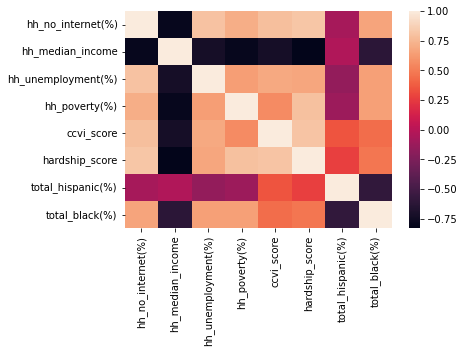

In [40]:
sns.heatmap(
    final_df[['hh_no_internet(%)','hh_median_income','hh_unemployment(%)','hh_poverty(%)','ccvi_score','hardship_score','total_hispanic(%)','total_black(%)']]
    .corr()
)

In [42]:
from sklearn.linear_model import LinearRegression

In [43]:
from sklearn import linear_model

In [44]:
import statsmodels.api as sm

### Linear Regression

In [65]:
# define the data/predictors as the pre-set feature names  
df = pd.DataFrame(final_df, columns=["hh_median_income"])

# Put the target (housing value -- MEDV) in another DataFrame
target = pd.DataFrame(final_df, columns=["hh_internet"])

In [66]:
X = df
y = target["hh_internet"]

In [67]:
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

In [68]:
lm.score(X,y)

0.22098485475992713

This is the R² score of our model or the percentage of explained variance of the predictions. It is pretty low at 22%, and represents a model that does explains a tiny amount of the variation in no internet access around its mean. 

In [69]:
lm.coef_

array([0.16566996])

In [70]:
lm.intercept_

1799.0099092159198

### OLS Regression

In [71]:
# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            hh_internet   R-squared (uncentered):                   0.670
Model:                            OLS   Adj. R-squared (uncentered):              0.666
Method:                 Least Squares   F-statistic:                              154.3
Date:                Wed, 02 Mar 2022   Prob (F-statistic):                    5.59e-20
Time:                        09:45:30   Log-Likelihood:                         -804.13
No. Observations:                  77   AIC:                                      1610.
Df Residuals:                      76   BIC:                                      1613.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
hh_median_income     0.1920      0.015     12.422      0.000       0.161       0.223
==============================================================================
Omnibus:                       26.046   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.880
Skew:                           1.182   Prob(JB):                     3.29e-12
Kurtosis:                       6.301   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- OLS stands for Ordinary Least Squares and the method “Least Squares” means that we’re trying to fit a regression line that would minimize the square of distance from the regression line (see the previous section of this post).
- The coefficient of 0.19 means that as the median income variable increases by 1, the predicted value of no internet access increases by 0.19.
- Household income accounts for 67% of the variance in internet access.